## Описание проекта

Интернет-магазин запускает новый сервис, благодаря которому пользователи смогут добавлять описания товаров: вносить собственные правки и комментировать действия других. 

Необходимо ускорить модерацию комментариев в сообществе, автоматизировав оценку их токсичности. Обучить модель классифицировать комментарии на позитивные и негативные.

### План решения задачи

* [1. Загрузка и подготовка данных](#1-bullet)
* [2. TF-IDF совместно с LogisticRegression](#2-bullet)
* [3. Модель BERT](#3-bullet)
* [4. Общие выводы](#4-bullet)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re

import eli5

from time import time

import textblob
from textblob import TextBlob

import nltk
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm

from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

from tqdm import tqdm, tqdm_notebook, notebook

import torch
import transformers

from scipy.stats import randint as sp_randint

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, confusion_matrix, classification_report, make_scorer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier

from sklearn.utils import shuffle

import warnings # отключение предупреждений
warnings.filterwarnings('ignore')

## 1. Загрузка и подготовка данных <a id='1-bullet'></a>

In [5]:
df = pd.read_csv('toxic_comments.csv')
df.head(5)

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


Выделим целевой признак и изучим баланс классов

In [7]:
target = df['toxic']
target.value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

In [8]:
def preprocessing(tweet):    

    tweet = tweet.lower()
    tweet = re.sub(r"(?:\n|\r)", " ", tweet)
    tweet = re.sub(r"[^a-zA-Z ]+", "", tweet).strip()
    
    return tweet

In [9]:
df['text'] = df['text'].apply(preprocessing)
df.head()

,text,toxic
0,explanation why the edits made under my userna...,0
1,daww he matches this background colour im seem...,0
2,hey man im really not trying to edit war its j...,0
3,more i cant make any real suggestions on impro...,0
4,you sir are my hero any chance you remember wh...,0


In [10]:
nlp = en_core_web_sm.load()
def lemmatize(tweet):
    temp = []
    for token in nlp(tweet):
        if token.is_stop == False:
            temp.append(token.lemma_)
    return " ".join(temp)

In [11]:
tqdm.pandas()
df['text'] = df['text'].progress_apply(lemmatize)

100%|██████████| 159571/159571 [45:35<00:00, 58.34it/s]


In [12]:
df.head()

,text,toxic
0,explanation edit username hardcore metallica f...,0
1,daww match background colour be seemingly stic...,0
2,hey man be try edit war guy constantly remove ...,0
3,not real suggestion improvement wonder secti...,0
4,sir hero chance remember page s,0


Текст предобработали: теперь он представляет собой леммы и состоит только из важных для анализа слов - без междометий, артиклей и предлогов.  

Данных у нас много, так что обучение может занять довольно много времени (особенно мой любимый *XGBoost*), да и наблюдается дисбаланс - позитивных комментариев гораздо больше негативных.

Пропусков нет, а значит можем приступать к самому интересному.

### 2. TF-IDF совместно с LogisticRegression <a id='2-bullet'></a>

Разделим данные на train и test с учетом дисбаланса с помощью  гиперпараметра *stratify*

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['toxic'], test_size=0.3, random_state=121, stratify=df['toxic'])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((111699,), (47872,), (111699,), (47872,))

Оценим важность слов в контексте с помощью *TF-IDF* и натренируем *LogisticRegression*, так как этот алгорим может обучиться довольно быстро на нашем большом датасете.

Создадим функцию *conf_visualize*, чтобы отрисовать *confusion matrix*.

In [14]:
def conf_visualize(y_test, y_pred):
    conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
    print('Confusion matrix:\n', conf_mat)
 
    labels = ['Toxic 0', 'Toxic 1']
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('Expected')
    plt.show()

In [15]:
pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', LogisticRegression(random_state=121, solver='liblinear'))
    ])

pipe.fit(X_train, y_train)
y_test_pred = pipe.predict(X_test)
print('F1 на test:', f1_score(y_test, y_test_pred))

F1 на test: 0.7351924975320828


In [16]:
# 5 главных слов

eli5.show_weights(pipe, top=5)

Результат немного не дотягивает до требуемого значения F1 в 0.75 - попробуем настроить гиперпараметры 

Обучение завершилось за 1469.80 секунд.
Лучшие гиперпараметры:  {'model': LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=121, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False), 'model__C': 1000.0, 'vectorizer__ngram_range': (1, 2)}
F1: 0.7857540345019478

               precision    recall  f1-score   support

           0       0.97      0.99      0.98     43004
           1       0.86      0.73      0.79      4868

    accuracy                           0.96     47872
   macro avg       0.91      0.86      0.88     47872
weighted avg       0.96      0.96      0.96     47872

Confusion matrix:
 [[42417   587]
 [ 1338  3530]]


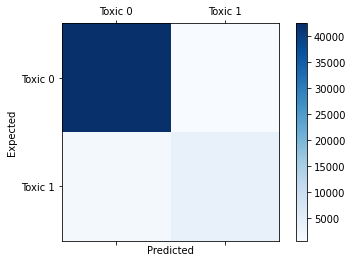

In [17]:
my_scorer = make_scorer(f1_score, greater_is_better=True) # параметр нашей целевой метрики

pipe = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 1))),
    ('model', LogisticRegression(random_state=121, solver='liblinear', max_iter=500))
    ])

params = [
          {
              'vectorizer__ngram_range': [(1, 1), (1, 2), (2, 2)],
              'model': [LogisticRegression(random_state=121, solver='liblinear')],
              'model__C': np.logspace(-3,3,7)

           }
]

logreg_cv = GridSearchCV(pipe, params, cv=5, scoring=my_scorer)

start = time()
logreg_cv.fit(X_train, y_train)
print("Обучение завершилось за %.2f секунд." % (time()-start))
print('Лучшие гиперпараметры: ', logreg_cv.best_params_)

prediction_test = logreg_cv.predict(X_test)

print('F1:', f1_score(y_test, prediction_test))
print('\n', classification_report(y_test, prediction_test))

conf_visualize(y_test, prediction_test)

Результат нас вполне устраивает, но попробует получить более высокие значения с помощью еще одного подхода.

### 3. Модель Bert <a id='3-bullet'></a>

#### Важный момент - Bert требует использовать токены не длинее 512 символов.

Кроме того, заполним нулями недостающие значения у небольших значений и подскажем модели, что внимания на эти данные обращать не надо.

In [18]:
tokenizer = transformers.BertTokenizerFast.from_pretrained('bert-base-uncased')

In [19]:
tokenized = df['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True, truncation=True, max_length=512))

In [20]:
# проверим максимальную и минимальную длину токена

max_len = max(map(len, tokenized))
print('Максимальная длина токена:', max(map(len, tokenized)))
print('Минимальная длина токена:', min(map(len, tokenized)))

Максимальная длина токена: 512
Минимальная длина токена: 2


Добавим нули и создадим маску

In [21]:
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
padded.shape

(159571, 512)

In [22]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(159571, 512)

Будем использовать стандартные параметры BertModel 

In [23]:
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Без GPU здесь не обойтись: на локальном компьютере процесс должен был занять 14 часов, тогда как с помощью GPU из Google Collab справились за полтора часа.

In [24]:
batch_size = 32
embeddings = []

for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
        batch = batch.to('cuda')
        attention_mask_batch = attention_mask_batch.to('cuda')
        model.to('cuda')

        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())
       

last_batch_idx = (padded.shape[0] // batch_size) * batch_size
rest_idx = list(range(last_batch_idx, padded.shape[0]))

batch = torch.LongTensor(padded[rest_idx]) 
attention_mask_batch = torch.LongTensor(attention_mask[rest_idx])
        
batch = batch.to('cuda')
attention_mask_batch = attention_mask_batch.to('cuda')
model.to('cuda')

with torch.no_grad():
    batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
embeddings.append(batch_embeddings[0][:,0,:].cpu().numpy())

#### Остается только:

- Окончательно определить наши признаки и таргет
- Разделить датасет на train и test
- Обучить *LogisticRegression*, *LinearSVC*, *XGBClassifier* и посмотреть результаты

In [25]:
features = np.concatenate(embeddings)
features.shape

(159571, 768)

In [26]:
target.shape

(159571,)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    target, 
    test_size=0.3,
    random_state=121,
    stratify=target)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((111699, 768), (47872, 768), (111699,), (47872,))

Датасет у нас сложный, так что время обучения крайне важный момент, особенно если мы будем помнить о долгой работе *BertModel*, без которой получить хороший результат у нас бы не получилось (я пытался).

#### LogisticRegression

In [31]:
start = time()

logreg = LogisticRegression(random_state=121)
logreg.fit(X_train, y_train)
prediction_test = logreg.predict(X_test)
print('F1:', f1_score(y_test, prediction_test))
print("Обучение завершилось за %.2f секунд." % (time()-start))

F1: 0.6877667140825036
Обучение завершилось за 17.34 секунд.


#### LinearSVC

In [29]:
start = time()

linear_svm = LinearSVC(random_state=121)
linear_svm.fit(X_train, y_train)
prediction_test = linear_svm.predict(X_test)
print('F1:', f1_score(y_test, prediction_test))
print("Обучение завершилось за %.2f секунд." % (time()-start))

F1: 0.6809295462928808
Обучение завершилось за 201.00 секунд.


#### XGBClassifier

In [30]:
start = time()

xgb_clf = XGBClassifier(random_state=121)
xgb_clf.fit(X_train, y_train)
prediction_test = xgb_clf.predict(X_test)
print('F1:', f1_score(y_test, prediction_test))
print("Обучение завершилось за %.2f секунд." % (time()-start))

F1: 0.5966618478118018
Обучение завершилось за 687.29 секунд.


Результаты получились слабые. Выделяется разве что *LinearSVC*, но обучать 
тот алгоритм требуется в десять раз дольше, чем *LogisticRegression*. И это без какого-либо перебора гиперпараметров. Посмотрим как справится тюнингованная регрессия, так как мы использовали именно ее в случае с *TF-IDF.

Лучшие гиперпараметры:  {'C': 10.0, 'penalty': 'l2'}
F1: 0.6864285714285715

               precision    recall  f1-score   support

           0       0.96      0.98      0.97     43004
           1       0.82      0.59      0.69      4868

    accuracy                           0.94     47872
   macro avg       0.89      0.79      0.83     47872
weighted avg       0.94      0.94      0.94     47872

Confusion matrix:
 [[42355   649]
 [ 1985  2883]]


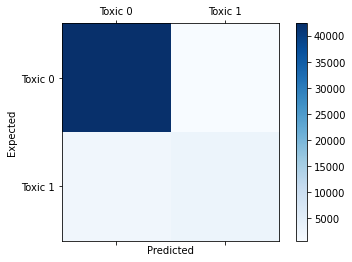

In [33]:
#my_scorer = make_scorer(f1_score, greater_is_better=True) # параметр нашей целевой метрики

grid = {'C':np.logspace(-3,3,7), 'penalty':['l1','l2']}
logreg = LogisticRegression(random_state=121)
#logreg_cv = GridSearchCV(logreg, grid, cv=5, scoring=my_scorer)
logreg_cv = GridSearchCV(logreg, grid, cv=5)
logreg_cv.fit(X_train, y_train)

print('Лучшие гиперпараметры: ',logreg_cv.best_params_)

prediction_test = logreg_cv.predict(X_test)
print('F1:', f1_score(y_test, prediction_test))
print('\n', classification_report(y_test, prediction_test))

conf_visualize(y_test, prediction_test)

#### Выводы <a id='4-bullet'></a>

- С помощью *TF-IDF* и *LogisticRegression* нам удалось добиться высоких значений F1: на тестовой выборке она превышает 0.75, о которых просил заказчик, и достигает 0.78. Данный подход оказался относительно быстрым и удобным.

- В то время как модель *BERT* отняла гораздо больше усилий/времени и не смогла показать хороший результат. Мы сильно ограничены мощностью нашего "железа". Возможно, если бы мы могли ощутимо ускорить время обучения и натренировать более сложные модели, то и конечные результаты оказались бы лучше. А так, самое высокое значение удалось получить с помощью базовой *LogisticRegression*: F1 - 0.68. 